In [1]:
import sys; sys.path.append('../../') 

from utils.data_cleaner import *
from data_collection_config import *
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

### Чтение и подготовка данных

In [2]:
Goods = pd.read_csv(f'{CLEAR_DIRECTORY}{CLEAR_GOODS_FILE}')
Other_characteristicks = pd.read_csv(f'{CLEAR_DIRECTORY}{CLEAR_OTHER_CHARACTERISTICKS_FILE}')
Feedbacks = pd.read_csv(f'{CLEAR_DIRECTORY}{CLEAR_FEEDBACKS_FILE}')

def prepare_goods(df):
    df['brand'] = df['brand'].fillna('Unknown')
    df['description'] = df['description'].fillna('')
    df['brand'] = df['brand'].str.lower().str.strip()

    # mask = df['name'].apply(is_relevant())
    # df = df[mask].copy()
    
    return df

def prepare_other_chars(df):
    df['name'] = df['name'].str.lower().str.strip()
    df['value'] = df['value'].str.lower().str.strip()
    
    df = df[df['value'].notna() & (df['value'] != '')]
    
    return df

def prepare_feedbacks(df):
    df['text'] = df['text'].fillna('')
    
    df['text'] = df['text'].str.lower().str.strip()
    
    return df

Goods = prepare_goods(Goods)
Goods = Goods[(Goods['price'] >= Goods['price'].quantile(0.01)) & (Goods['price'] <= Goods['price'].quantile(0.95))]
Other_characteristicks = prepare_other_chars(Other_characteristicks)
Feedbacks = prepare_feedbacks(Feedbacks)

# Goods.info()
# Other_characteristicks.info()
# Feedbacks.info()

## Выделение главных характеристик

In [3]:
print("Всего уникальных характеристик:", Other_characteristicks['name'].nunique())
print(Other_characteristicks['name'].value_counts().head(50))

Всего уникальных характеристик: 45
name
тип                                         68
артикул                                     68
зоны массажа                                61
комплектация                                59
цвет                                        55
страна-изготовитель                         50
вид массажа                                 41
упаковка                                    31
особенности массажного аппарата             27
вид питания                                 23
гарантийный срок                            21
материал корпуса                            20
фактический размер товара, см               20
количество программ/режимов                 11
страна производства                         10
высота упаковки                              9
длина упаковки                               9
ширина упаковки                              9
высота предмета                              7
единиц в одном товаре                        7
максимальный рост по

In [4]:
pivot_df = Other_characteristicks.pivot_table(
    index=['good_id', 'marketplace'],
    columns='name',
    values='value',
    aggfunc='first'
).reset_index()

pivot_df.columns.name = None

main_specs = pivot_df[['good_id', 'marketplace', 'комплектация']]

main_specs['комплектация'] = main_specs['комплектация'].str.replace(r'\D', '', regex=True)

main_specs

/var/folders/x5/m9f65fq57_1642g0ls7c0zxw0000gn/T/ipykernel_2236/1215169110.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  main_specs['комплектация'] = main_specs['комплектация'].str.replace(r'\D', '', regex=True)


,good_id,marketplace,комплектация
0,91044173,wb,1
1,162818043,wb,1
2,205925103,wb,1
3,205925986,wb,1
4,205929840,wb,2
...,...,...,...
78,2634695095,ozon,2
79,2778913007,ozon,1
80,2779820474,ozon,1
81,2793997163,ozon,


# Анализ рынка кабелей для электродов для электростимуляторов

## Введение

Необходимо понять, как выглядит текущая рыночная ситуация на рынке кабелей для электродов для электростимуляторов. 

Были сформулированы 4 цели:
- Определить, в каком ценовом сегменте выгоднее всего конкурировать
- Понять, какие функции и характеристики наиболее популярны у потребителей
- Оценить уровень конкуренции
- Выявить возможные ниши

## Описание источников и подхода к сбору данных

Для достижения поставленных целей в первую очередь необходимо подготовить набор данных. Данные собраны с двух маркетплейсов: Wildberries и Ozon.
Для этих маркетплейсов были разработаны парсеры с помощью Python + requests/Selenium. Парсеры организованы в 2 класса: WB_Parser и Ozon_Parser. Данные классы имеют 3 открытых метода: 
- get_products() - собирает все имеющиеся товары на маркетплейсе, соответсвующие запросу; 
- get_product_feedbacks() - собирает отзывы на заданный товар;
- get_product_details() - собирает описание и характеристики заданного товара.

С обоих площадок было собрано > 80 товаров.

После сбора, данные были очищены и собраны в 3 таблицы:
- Goods (основные характеристики товаров)
- Feedbacks (отзывы пользователей)
- Other_characteristics (доп. характеристики)

В итоге получилось 81 товар и >4 938 отзывов о них

Состав таблиц:

In [5]:
Goods.info()
Other_characteristicks.info()
Feedbacks.info()

<class 'pandas.core.frame.DataFrame'>
Index: 81 entries, 0 to 86
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           81 non-null     int64  
 1   marketplace  81 non-null     object 
 2   name         81 non-null     object 
 3   price        81 non-null     int64  
 4   rating       81 non-null     float64
 5   feedbacks    81 non-null     int64  
 6   brand        81 non-null     object 
 7   description  81 non-null     object 
dtypes: float64(1), int64(3), object(4)
memory usage: 5.7+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 673 entries, 0 to 672
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   good_id      673 non-null    int64 
 1   marketplace  673 non-null    object
 2   name         673 non-null    object
 3   value        673 non-null    object
dtypes: int64(1), object(3)
memory usage: 21.2+ KB
<class 'pandas.core.

## Как выглядит рынок кабелей для электродов? (Распределение цен)

In [6]:
price_data = Goods['price'].copy()

stats = {
    'Средняя цена': f"{price_data.mean():,.0f} руб",
    'Медианная цена': f"{price_data.median():,.0f} руб",
    'Минимальная цена': f"{price_data.min():,.0f} руб",
    'Максимальная цена': f"{price_data.max():,.0f} руб",
    'Стандартное отклонение': f"{price_data.std():,.0f} руб",
    '95-й перцентиль': f"{price_data.quantile(0.95):,.0f} руб"
}

print("Ключевые метрики распределения цен:")
for k, v in stats.items():
    print(f"{k}: {v}")

Ключевые метрики распределения цен:
Средняя цена: 378 руб
Медианная цена: 327 руб
Минимальная цена: 133 руб
Максимальная цена: 1,302 руб
Стандартное отклонение: 221 руб
95-й перцентиль: 839 руб


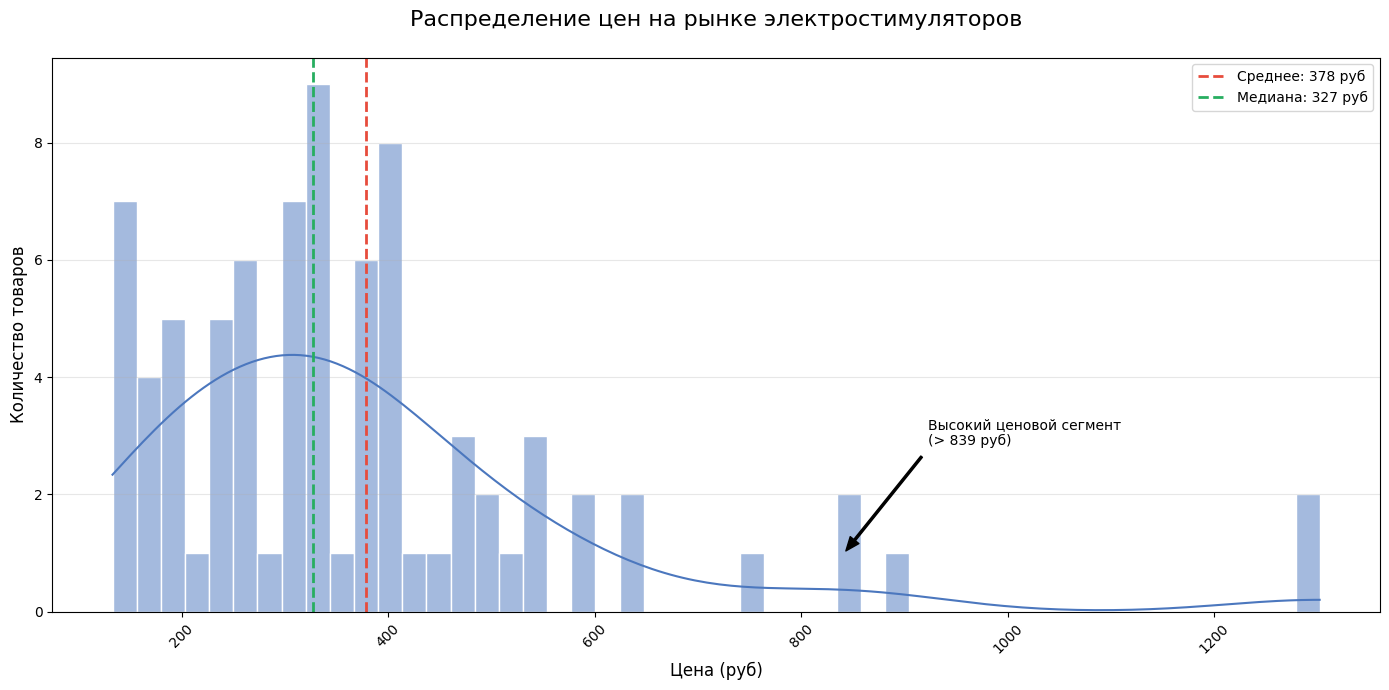

In [7]:
price_data = Goods["price"]

plt.figure(figsize=(14, 7))

ax = sns.histplot(price_data, bins=50, kde=True, 
                 color='#4B77BE', edgecolor='white')

mean_price = price_data.mean()
median_price = price_data.median()

plt.axvline(mean_price, color="#E74C3C", linestyle='--', 
           linewidth=2, label=f'Среднее: {mean_price:,.0f} руб')
plt.axvline(median_price, color='#27AE60', linestyle='--',
           linewidth=2, label=f'Медиана: {median_price:,.0f} руб')

q95 = price_data.quantile(0.95)
outliers = price_data[price_data > q95]

y_max = ax.get_ylim()[1]
if len(outliers) > 0:
    plt.annotate(f'Высокий ценовой сегмент\n(> {q95:,.0f} руб)',
                xy=(q95, y_max * 0.1),           
                xytext=(q95 * 1.1, y_max * 0.3), 
                arrowprops=dict(facecolor='black', 
                              shrink=0.05,
                              width=1.5,         
                              headwidth=8,       
                              headlength=10), 
                fontsize=10,
                ha='left')

plt.title('Распределение цен на рынке электростимуляторов\n', fontsize=16)
plt.xlabel('Цена (руб)', fontsize=12)
plt.ylabel('Количество товаров', fontsize=12)
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.ticklabel_format(style='plain', axis='x')
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

In [8]:
from sklearn.cluster import KMeans

price_segment_clear_df = Goods.copy()

prices = price_segment_clear_df["price"].values.reshape(-1, 1)
kmeans = KMeans(n_clusters=4, random_state=42).fit(prices)
price_segment_clear_df['price_segment'] = kmeans.labels_

def min_max(price_segment, df):
    return int(df[df["price_segment"] == price_segment]["price"].min()), int(df[df["price_segment"] == price_segment]["price"].max())

min_max_segments = {}
for i in range(4):
    min_max_segments[i] = min_max(i, price_segment_clear_df)

min_max_segments = sorted(min_max_segments.items(), key=lambda item: item[1] )

print(f"Низкий ценовой сегмент: {min_max_segments[0][1]}")
print(f"Средний ценовой сегмент: {min_max_segments[1][1]}")
print(f"Средне-высокий ценовой сегмент:{min_max_segments[2][1]}")
print(f"Высокий ценовой сегмент:  {min_max_segments[3][1]}")

Низкий ценовой сегмент: (133, 274)
Средний ценовой сегмент: (305, 513)
Средне-высокий ценовой сегмент:(532, 885)
Высокий ценовой сегмент:  (1302, 1302)


In [9]:
import pandas as pd
pd.set_option('display.max_colwidth', None)

def top_specs(df, column, top_n, stats):
    zones = df[column].str.split('[;,/]', expand=True).stack().str.strip()
    top_zones = zones.value_counts().head(top_n)
    stats.update({
        f'топ {top_n} {column}': '; '.join([f"{zone} ({count})" for (zone, count) in top_zones.items()])
    })

def get_segment_stats(segment_df, segment_name, top_n):
    stats = {
        'Сегмент': segment_name,
        'Кол-во товаров': len(segment_df),
        'Доля товаров без бренда': len(segment_df[segment_df['brand'] == 'unknown']) / len(segment_df),
        'Средний рейтинг': segment_df['rating'].median(),
        'Среднее кол-во отзывов': segment_df['feedbacks'].median()
    }
    
    # Топ брендов
    top_brands = segment_df['brand'].value_counts().head(top_n)
    stats.update({
        f'топ {top_n} брендов': '; '.join([f"{brand} ({count})" for (brand, count) in top_brands.items()])
    })
    
    return stats

low_price_df = price_segment_clear_df[price_segment_clear_df["price_segment"] == min_max_segments[0][0]]
mid_price_df = price_segment_clear_df[price_segment_clear_df["price_segment"] == min_max_segments[1][0]]
mid_high_price_df = price_segment_clear_df[price_segment_clear_df["price_segment"] == min_max_segments[2][0]]
high_price_df = price_segment_clear_df[price_segment_clear_df["price_segment"] == min_max_segments[3][0]]

segments = {
    'Низкий': low_price_df,
    'Средний': mid_price_df,
    'Средне-высокий': mid_high_price_df,
    'Высокий': high_price_df
}

top_n = 5
all_stats = [get_segment_stats(df, name, top_n) for name, df in segments.items()]
result_df = pd.DataFrame(all_stats)

display(result_df)
pd.reset_option('display.max_colwidth')

,Сегмент,Кол-во товаров,Доля товаров без бренда,Средний рейтинг,Среднее кол-во отзывов,топ 5 брендов
0,Низкий,29,0.000000,5.0,3.0,массажеры (19); миостимуляторы (6); ashop (2); массажеры для головы и лица (1); helendanny (1)
1,Средний,39,0.025641,4.8,53.0,миостимуляторы (13); массажеры (13); миостимулятор (4); ashop (4); the basket (3)
2,Средне-высокий,11,0.454545,4.5,4.0,unknown (5); the basket (1); миостимулятор (1); beurer (1); миостимуляторы (1)
3,Высокий,2,1.000000,0.0,0.0,unknown (2)


In [41]:
Goods_main_spec = pd.merge(
    Goods, 
    main_specs,
    how='left',
    left_on=['id', 'marketplace'],
    right_on=['good_id', 'marketplace']
)

electrod_1 = Goods_main_spec[Goods_main_spec['комплектация'] == '1']['price'].describe()
electrod_2 = Goods_main_spec[Goods_main_spec['комплектация'] == '2']['price'].describe()
electrod_4 = Goods_main_spec[Goods_main_spec['комплектация'] == '4']['price'].describe()

summary_df = pd.DataFrame({
    'Комплектация 1': electrod_1,
    'Комплектация 2': electrod_2,
    'Комплектация 4': electrod_4
})

print("📈 СВОДНАЯ СТАТИСТИКА ЦЕН по электродам")
print("=" * 65)
print(summary_df.round(2))

📈 СВОДНАЯ СТАТИСТИКА ЦЕН по электродам
       Комплектация 1  Комплектация 2  Комплектация 4
count           34.00            5.00            4.00
mean           304.00          347.80          437.00
std            158.32          122.34          184.53
min            133.00          197.00          195.00
25%            183.75          319.00          342.00
50%            258.00          323.00          485.50
75%            382.00          364.00          580.50
max            885.00          536.00          582.00


## 1. О рынке

**Рынок компактный:**
- Всего 81 товар в анализе
- Цены колеблются от 133 до 1 302 руб
- Распределение близко к нормальному: средняя цена (378 руб) ненамного превышает медиану (327 руб)
- Умеренная волатильность: стандартное отклонение 221 руб

На самом деле рынок состоит в массе своей из простейшего шнура с коннектором для миостимулятора и коннектором/коннекторами для электродов. Основное различие - количество коннекторов к электродам. 

Большая часть этих шнуров имеет цену < 600 рублей. На самом деле здесь даже сложно выделить ценовые сегменты в связи с однообразностью представленных моделей. 

В основном рынок представлен моделями с конекторами на 1, 2 или 4 электрода со средней ценой ~304, 347 и 437 руб. соотвественно.

/var/folders/x5/m9f65fq57_1642g0ls7c0zxw0000gn/T/ipykernel_2236/1095736399.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


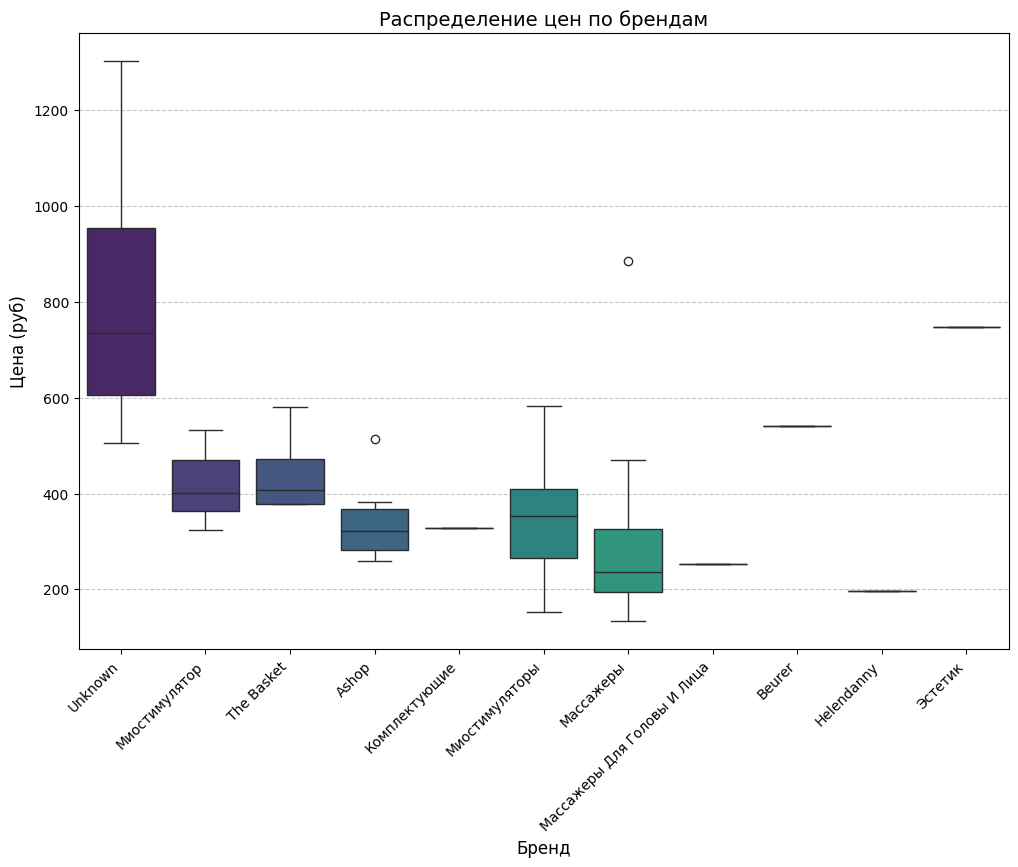

In [42]:
clear_df = Goods.copy()

boxplot_df = clear_df.dropna(subset=["brand"])
boxplot_df['brand'] = boxplot_df['brand'].str.strip().str.title()

top_brands = boxplot_df['brand'].value_counts().head(20).index  # Топ-20 брендов
df_filtered = boxplot_df[boxplot_df['brand'].isin(top_brands)]

plt.figure(figsize=(12, 8))
sns.boxplot(
    data=df_filtered,
    x='brand',
    y='price',
    palette='viridis'
)
plt.title('Распределение цен по брендам', fontsize=14)
plt.xlabel('Бренд', fontsize=12)
plt.ylabel('Цена (руб)', fontsize=12)
plt.xticks(rotation=45, ha='right')  # Поворот подписей
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [43]:
Goods['brand'].value_counts().head(20)

brand
массажеры                      33
миостимуляторы                 20
unknown                         8
ashop                           6
миостимулятор                   5
the basket                      4
комплектующие                   1
массажеры для головы и лица     1
beurer                          1
helendanny                      1
эстетик                         1
Name: count, dtype: int64

В основном товары представлены неизвестными брендами.

## Реакция потребителей (Анализ отзывов и рейтингов)

Что касается самых популярных характерстик:

In [44]:
def plot_top_main_specs(df, column, top_n, color):
    spec_df = df[column].str.split('[;,/]', expand=True).stack().str.strip()

    figsize = (15, 3)

    plt.figure(figsize=figsize)
    spec_df.value_counts().head(top_n).plot(kind='bar', color=color)
    plt.title(f'Топ-{top_n} {column}')
    plt.ylabel('Количество товаров')
    plt.xticks(rotation=30)
    plt.grid(axis='y', alpha=0.3)
    plt.show()

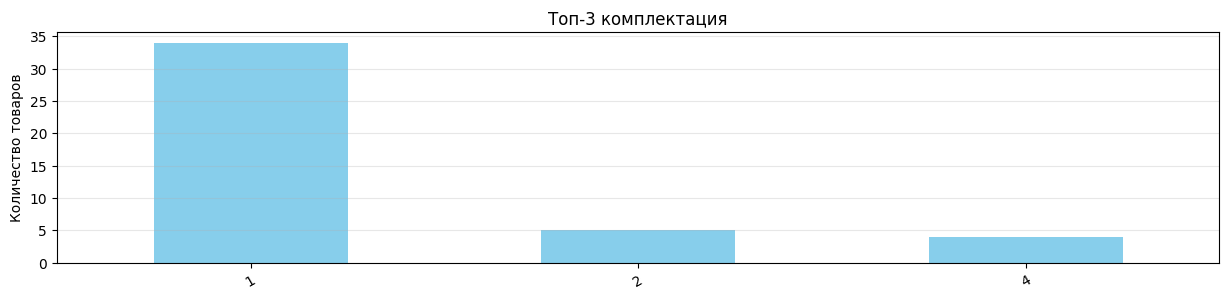

In [45]:
plot_top_main_specs(main_specs, 'комплектация', 3, 'skyblue')

Основную часть рынка сотсавляют кабели на 1, 2 и 4 элеткрода.

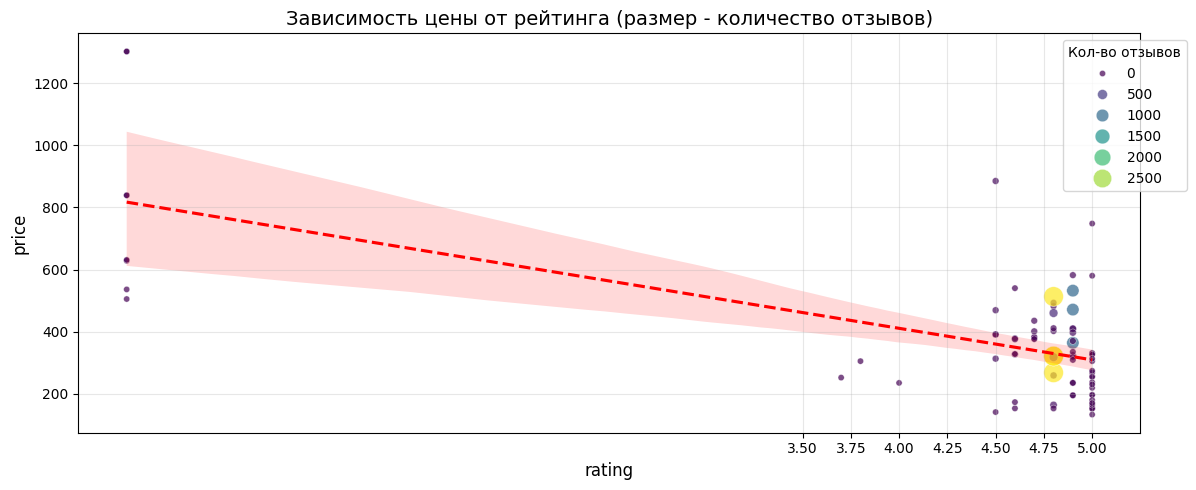

In [46]:
plt.figure(figsize=(12, 5))
sns.scatterplot(data=Goods, x='rating', y='price', 
                hue='feedbacks', size='feedbacks',
                sizes=(20, 200), alpha=0.7, palette='viridis')

plt.title('Зависимость цены от рейтинга (размер - количество отзывов)', fontsize=14)
plt.xlabel('Рейтинг', fontsize=12)
plt.ylabel('Цена (руб)', fontsize=12)
plt.xticks(np.arange(3.5, 5.1, 0.25))
plt.grid(alpha=0.3)
plt.ticklabel_format(style='plain', axis='y')

# Добавляем линию тренда
sns.regplot(data=Goods, x='rating', y='price', 
           scatter=False, color='red', line_kws={'linestyle':'--'})

plt.legend(title='Кол-во отзывов', bbox_to_anchor=(1.05, 1))
plt.tight_layout()
plt.show()

Мы видим устойчивую обратную зависимость рейтинга от цены.

/var/folders/x5/m9f65fq57_1642g0ls7c0zxw0000gn/T/ipykernel_2236/1583506022.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  box_plot = sns.boxplot(data=clear_df, x='rating_group', y='price',


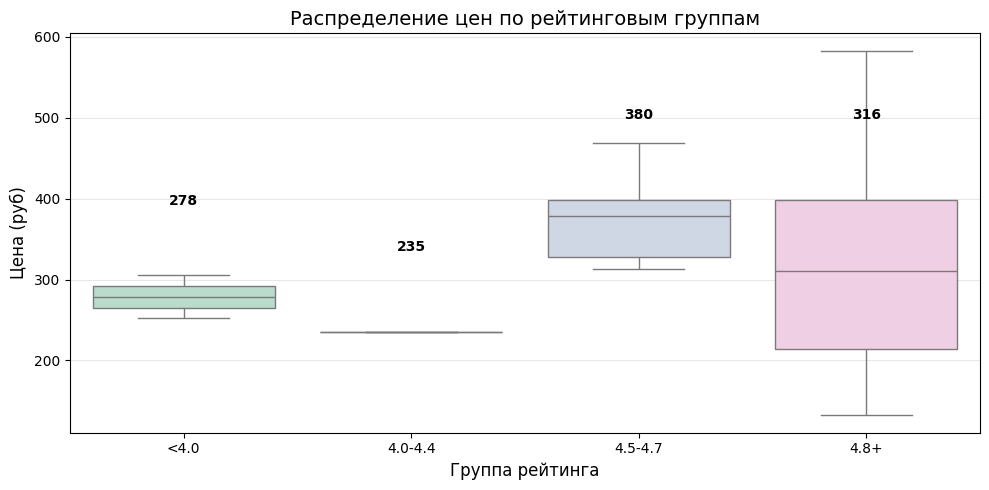

Средние цены по группам:
rating_group
<4.0       278.500000
4.0-4.4    235.000000
4.5-4.7    380.000000
4.8+       315.692308
Name: price, dtype: float64


In [ ]:
plt.figure(figsize=(10, 5))

clear_df = Goods.copy()

clear_df['rating_group'] = pd.cut(clear_df['rating'], 
                                   bins=[0, 3.9, 4.4, 4.7, 5],
                                   labels=['<4.0', '4.0-4.4', '4.5-4.7', '4.8+'])

box_plot = sns.boxplot(data=clear_df, x='rating_group', y='price', 
                      palette='Pastel2', showfliers=False)

plt.title('Распределение цен по рейтинговым группам', fontsize=14)
plt.xlabel('Группа рейтинга', fontsize=12)
plt.ylabel('Цена (руб)', fontsize=12)
plt.grid(axis='y', alpha=0.3)

means = clear_df.groupby('rating_group', observed=False)['price'].mean()

for i, (group, mean) in enumerate(means.items()):
    median_val = clear_df[clear_df['rating_group'] == group]['price'].median()
    y_pos = clear_df[clear_df['rating_group'] == group]['price'].quantile(0.75) + 100
    
    plt.text(i, y_pos, f'{mean:,.0f}', 
            ha='center', fontweight='bold', fontsize=10)

plt.tight_layout()
plt.show()

print("Средние цены по группам:")
print(means)

Высоким рейтингом обладают товары среднего ценового сегмента.

#### Анализ текстов

In [57]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer

nltk.download('stopwords')

df = Feedbacks

def clean_text(text):
    if pd.isna(text): 
        return ""
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    stop_words = set(stopwords.words('russian'))
    stemmer = SnowballStemmer('russian')
    words = text.split()
    words = [stemmer.stem(word) for word in words if word not in stop_words and len(word) > 2]
    return " ".join(words)

def generate_wordcloud(text, title):
    wordcloud = WordCloud(
        width=800, 
        height=400,
        background_color='white',
        max_words=50
    ).generate(text)
    
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.title(title)
    plt.show()
df['text_clean'] = df['text'].apply(clean_text)

positive = df[df['rating'] > 3]
negative = df[df['rating'] <= 3]

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/nekitmilk/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


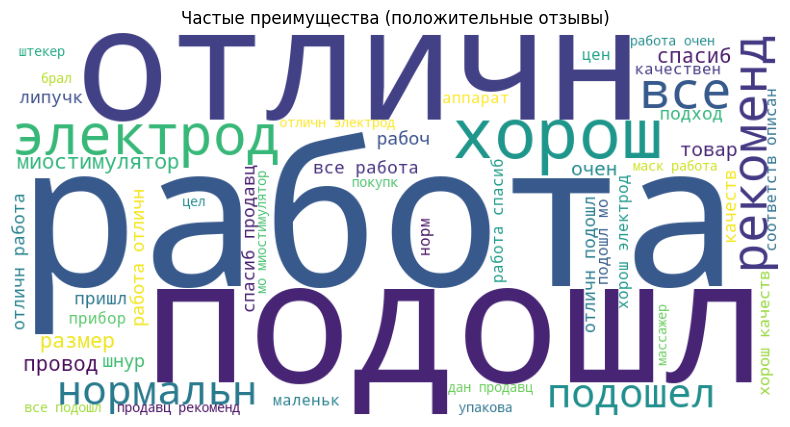

In [58]:
all_positive = " ".join(positive['text_clean'])
generate_wordcloud(all_positive, 'Частые преимущества (положительные отзывы)')

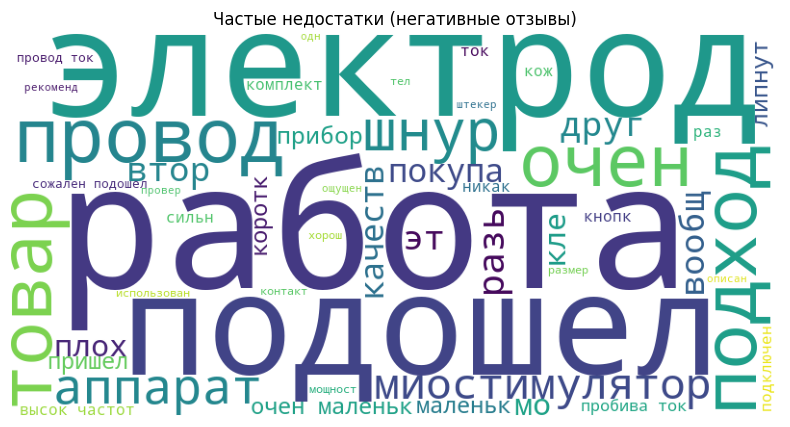

In [59]:
all_negative = " ".join(negative['text_clean'])
generate_wordcloud(all_negative, 'Частые недостатки (негативные отзывы)')

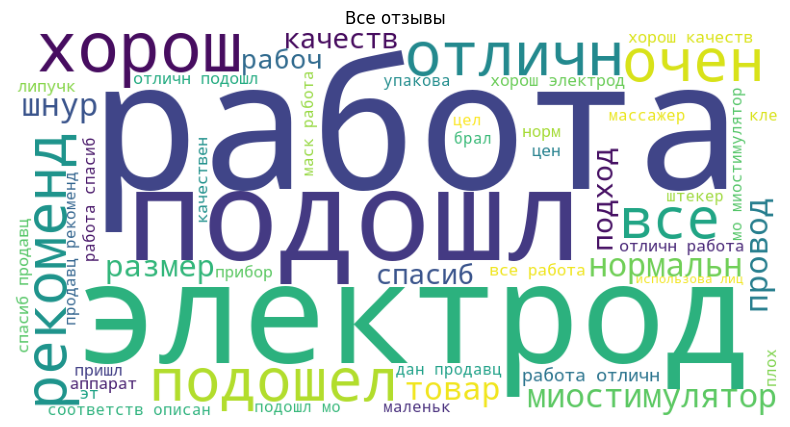

In [60]:
all_feedbacks = " ".join(df['text_clean'])
generate_wordcloud(all_feedbacks, 'Все отзывы')

In [61]:
def get_tfidf_top_features(texts, n=10, use_idf=False, use_mean=True):
    tfidf = TfidfVectorizer(max_features=100, ngram_range=(1, 2))

    tfidf_matrix = tfidf.fit_transform(texts)
    feature_names = tfidf.get_feature_names_out()
    
    if use_idf:
        sorted_indices = tfidf.idf_.argsort()
        return feature_names[sorted_indices][:n].tolist()
    
    if use_mean:
        aggregated = tfidf_matrix.mean(axis=0).A1
    else:
        aggregated = tfidf_matrix.sum(axis=0).A1
    
    sorted_indices = aggregated.argsort()[::-1]  # Сортировка по убыванию
    return feature_names[sorted_indices][:n].tolist()

In [62]:
top_positive_adv = get_tfidf_top_features(positive['text_clean'])
top_negative_dis = get_tfidf_top_features(negative['text_clean'], n=20)
print("Топ-10 слов (положительные отзывы, преимущества):", top_positive_adv)
print("Топ-20 слов (негативные отзывы, недостатки):", top_negative_dis)

Топ-10 слов (положительные отзывы, преимущества): ['работа', 'отличн', 'подошл', 'хорош', 'все', 'электрод', 'спасиб', 'провод', 'товар', 'рекоменд']
Топ-20 слов (негативные отзывы, недостатки): ['работа', 'подошел', 'провод', 'очен', 'товар', 'плох', 'размер', 'подход', 'шнур', 'электрод', 'маленьк', 'штекер', 'пришел', 'аппарат', 'возврат', 'ток', 'тонк', 'миостимулятор', 'никак', 'так']


In [64]:
print(f"Доля позитивных отзывов от общего количества: {(len(positive)*100/(len(positive) + len(negative))):.2f}%")

Доля позитивных отзывов от общего количества: 92.53%


Потребители в основном оценивают данные устроства положительно. 

В негативных отзывах сложно выделить основные жалобы, но можно отметить:
- длинна провода
- провод не подошел
- работа

## Выводы:

В основной массе пользователи положительно оценивают данные товары (> 90% положительных отзывов).

Идеальный продукт выглядит так: качественный провод среднего ценового сегмента на несколько электродов, который подойдет к аппарату.

Оптимальный сегмент для запуска - средний/средне-высокий, поскольку другие ценовые сегменты не имеют популярности.

Не идеальный - низкий и высокий, поскольку они не пользуются популярностью у потребителя.

Конкуренция на рынке низкая, поскольку на 2-х крупнеших маркетплейсах (Ozon и Wildberries) представлено < 100 товаров. 